In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np


In [11]:
!pip install pillow_heif
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.9 MB/s eta 0:00:00


In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
class ImageCombinerCNN(nn.Module):
    def __init__(self, num_inputs):
        super(ImageCombinerCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_inputs, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.activation(x)
        return x


In [12]:
import rasterio
import PIL
import os
import subprocess

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_stack = []
        for path in self.image_paths[idx]:
            if os.path.exists(path):
                try:
                    img = Image.open(path)
                except PIL.UnidentifiedImageError:
                    try:
                        with rasterio.open(path) as src:
                            img_data = src.read(1)
                            img = Image.fromarray(img_data)
                    except rasterio.errors.RasterioIOError:
                        print(f"Warning: Could not read {path} with rasterio. Attempting GDAL conversion...")
                        try:
                            converted_path = path + "_converted.tif"
                            subprocess.run(['gdal_translate', '-co', 'COMPRESS=LZW', path, converted_path], check=True)
                            print(f"Converted file saved to: {converted_path}")
                            with rasterio.open(converted_path) as src:
                                img_data = src.read(1)
                                img = Image.fromarray(img_data)
                        except subprocess.CalledProcessError as e:
                            print(f"Error converting file with GDAL: {e}")
                            continue
                        except rasterio.errors.RasterioIOError:
                            print(f"Warning: Could not read converted file {converted_path}. Skipping.")
                            continue
                image_stack.append(img)
            else:
                print(f"Warning: File not found: {path}")

        if self.transform:
            image_stack = [self.transform(img) for img in image_stack]
        if image_stack:
            images_tensor = torch.cat(image_stack, dim=0)
        else:
            raise ValueError("No images could be loaded for this item.")
        return images_tensor

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])


In [13]:
train_dataset = ImageDataset(image_paths=[['/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Bhukia_Banswara_AM_500n500(n760to1360).tif', '/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Forms_Lineaments_500n500_Cu_1.tif','/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Geology_Forn_Affinity_500n500_1.tif','/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/LithoAFF_500n500_Cu_1.tif']], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageCombinerCNN(num_inputs=4).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(10):
    for inputs in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        targets = torch.ones_like(inputs[:, :1, :, :]).to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.6674703359603882
Epoch 2, Loss: 0.6426327228546143
Epoch 3, Loss: 0.6166574954986572
Epoch 4, Loss: 0.5887982249259949
Epoch 5, Loss: 0.5584943890571594
Epoch 6, Loss: 0.5256021022796631
Epoch 7, Loss: 0.4894307255744934
Epoch 8, Loss: 0.4502439796924591
Epoch 9, Loss: 0.40844008326530457
Epoch 10, Loss: 0.36480680108070374


In [15]:
model = model.to(device)

In [18]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

def load_images(image_paths):
    images = []
    for path in image_paths:
        img = transform(Image.open(path))
        images.append(img)

    images_tensor = torch.cat(images, dim=0)
    print("Concatenated images tensor shape:", images_tensor.shape)

    images_tensor = images_tensor.unsqueeze(0)
    print("Final input tensor shape:", images_tensor.shape)

    return images_tensor


In [19]:
model.eval()

def generate_combined_image(model, image_paths):
    with torch.no_grad():
        input_tensor = load_images(image_paths)
        input_tensor = input_tensor.to(device)

        print("Corrected Input tensor shape:", input_tensor.shape)
        output_tensor = model(input_tensor)
        output_image = output_tensor.squeeze(0).squeeze(0)
        return output_image

image_paths = ['/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Bhukia_Banswara_AM_500n500(n760to1360).tif', '/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Forms_Lineaments_500n500_Cu_1.tif','/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Geology_Forn_Affinity_500n500_1.tif','/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/LithoAFF_500n500_Cu_1.tif']

combined_image = generate_combined_image(model, image_paths)


Concatenated images tensor shape: torch.Size([4, 500, 500])
Final input tensor shape: torch.Size([1, 4, 500, 500])
Corrected Input tensor shape: torch.Size([1, 4, 500, 500])


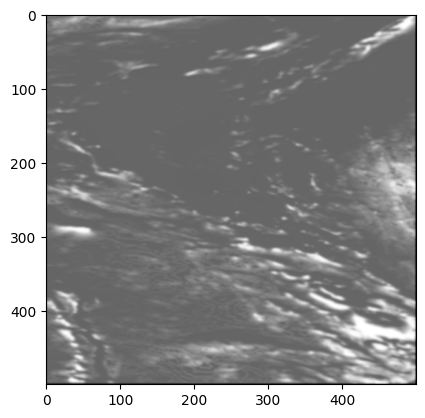

In [20]:
import matplotlib.pyplot as plt

def tensor_to_image(tensor):
    tensor = tensor.cpu().numpy()
    plt.imshow(tensor, cmap='gray')
    plt.show()

tensor_to_image(combined_image)


In [21]:
def save_image(tensor, file_path):
    tensor = tensor.cpu().numpy()
    image = Image.fromarray((tensor * 255).astype('uint8'), mode='L')
    image.save(file_path)

save_image(combined_image, '/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/combined_image_CNN.tif')

In [22]:
from PIL import Image
import numpy as np
import os

def load_and_convert_to_mask(image_path):
    with Image.open(image_path) as img:
        return np.array(img.convert('L').point(lambda x: x > 127, '1'), dtype=bool)

def combine_masks(image_paths):
    combined_mask = None

    for path in image_paths:
        mask = load_and_convert_to_mask(path)
        if combined_mask is None:
            combined_mask = mask
        else:
            combined_mask |= mask

    return combined_mask

def save_mask_as_image(mask, output_path):
    img = Image.fromarray(mask, mode='1')
    img.save(output_path, format='TIFF')

image_paths = ['/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Bhukia_Banswara_AM_500n500(n760to1360).tif', '/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Forms_Lineaments_500n500_Cu_1.tif','/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/Geology_Forn_Affinity_500n500_1.tif','/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/LithoAFF_500n500_Cu_1.tif']
combined_mask = combine_masks(image_paths)
save_mask_as_image(combined_mask, '/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/combined_image.tif')


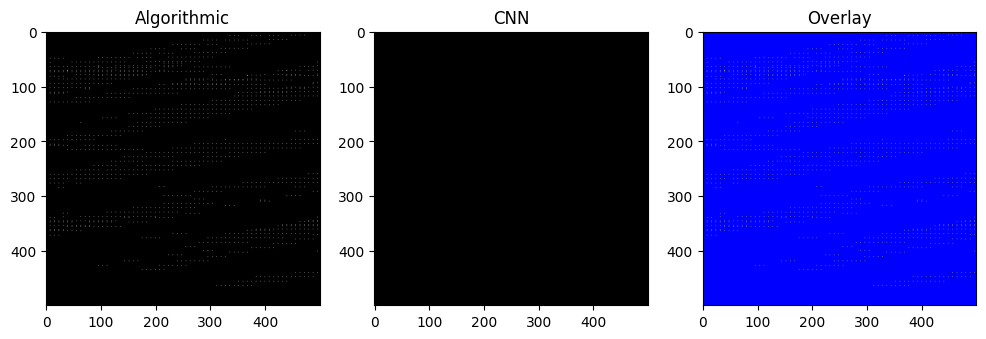

In [23]:
def load_and_threshold(image_path):
    with Image.open(image_path) as img:
        binary = img.convert("L").point(lambda x: x > 128, '1')
        return np.array(binary, dtype=bool)

image1 = load_and_threshold('/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/combined_image.tif')
image2 = load_and_threshold('/content/drive/MyDrive/TESTOUTPUTS_GSI (extract.me)/combined_image_CNN.tif')

overlay = np.zeros((*image2.shape, 3), dtype=np.uint8)
overlay[image1 & image2] = [255, 255, 0]
overlay[image1 & ~image2] = [255, 0, 0]
overlay[~image1 & image2] = [0, 0, 255]

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image1, cmap='gray')
plt.title('Algorithmic')
plt.subplot(1, 3, 2)
plt.imshow(image2, cmap='gray')
plt.title('CNN')
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title('Overlay')
plt.show()

# Yellow where both are white
# Red where only image1 is white
# Blue where only image2 is white


In [26]:
def calculate_metrics(img1, img2):
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    iou = np.sum(intersection) / np.sum(union)

    return iou

iou = calculate_metrics(image1, image2)
print(f"Intersection over Union: {iou:.2f}")


Intersection over Union: 0.01
